When a team goes on an extended winning streak, my gut tells me that something so unlikely is happening that it *proves* sports contests must be more than just weighted random number generators.  <br>
But is that true?  In an attempt to answer that question, I work out the probabilities of winning streaks of different lengths given a winning percentage, and estimate that for each team given their (2018) records.  I compare those odds to the actual lengths of winning streaks for that season. <br>
I admit, what I find is a little surprising.

## Python packages
We start by importing some standard Python packages:

In [1]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn

%matplotlib inline
plt.style.use('ggplot')

sys.setrecursionlimit(20000)

Next, since we want to know how unlikely are long winning streaks, we need to estimate what those odds are in theory, from simple statistics. <br>
Here I'll use a recursive algorithm to estimate the probability of a streak of length winStreak during a season numGames long, for a team whose season-long record is winPercent. <br>
Naturally, we expect the probability to increase for:
- shorter streaks
- better teams 
- longer seasons

In [10]:
def probability_of_streak(numGames, winStreak, winPercent, saved = None):
        
        if saved == None: saved = {}
        
        ID = (numGames, winStreak, winPercent)
        
        if ID in saved: return saved[ID]
        else: 
            if winStreak > numGames or numGames <=0:
                result = 0
            else:
                result = winPercent**winStreak
                for firstWin in range(1, winStreak+1):
                    pr = probability_of_streak(numGames-firstWin, winStreak, winPercent, saved)
                    result += (winPercent**(firstWin-1))*(1-winPercent)*pr

        saved[ID] = result
                               
        return result

Define a function splits the season into arrays representing winning streaks.  

In [3]:
def consecutive(data, stepsize=0):
    # define an empty array the length of a season and replace 0 with 1 for each Win.
    sched = np.zeros(np.size(data))
    sched[np.isin(data,'W')] = 1
    # split into chunks of winning streaks
    return np.split(sched, np.where(np.diff(sched) != stepsize)[0]+1)

Define a function to group streaks by wins and losses.

In [4]:
def group_streaks(sched):
    all_streaks = consecutive(sched)
    longest_streak = np.size(max(all_streaks,key=len))
    wins = np.zeros(longest_streak,dtype=np.int)
    loss = np.zeros(longest_streak, dtype=np.int)
    for i in all_streaks:
        ind = np.size(i)-1
        if i[0] == 1:
            wins[ind] += 1
        else:
            loss[ind] += 1
            
    return [wins, loss]    

In [5]:
def winning_percentage(streaks):
    wp = {}
    gp = {}
    for team in streaks:
        total_number_games = np.sum((np.arange(np.size(streaks[team][0]))+1) * streaks[team][0]) + np.sum((np.arange(np.size(streaks[team][1]))+1) * streaks[team][1])
        gp[team] = total_number_games
        wp[team] = np.sum((np.arange(np.size(streaks[team][0]))+1) * streaks[team][0]) / total_number_games
    return wp,gp

## Download Data
The following files were grabbed from Baseball Reference. I store them in directories categorized by year, as well as Al and NL. 

In [6]:
path_files = '/data/baseball/Baseball-Reference/schedule_results/2018/'
leagues    = ['AL','NL']

We loop through each Leage and Team, storing Wins and Losses as W and L in a Pandas Dataframe.  Additionally, we convert walk-off wins and losses ('W-wo', 'L-wo') to 'W' and 'L'. <br>
Lastly, we store streaks for each team in a streaks dictionary.

In [7]:
streaks = {}
for league in leagues:
    path_csv = path_files + league + '/'
    fnames = os.listdir(path_csv)
    for itm in fnames:
        team = itm.split('.')[0].split('_')[0]
        pd.read_csv(path_csv+itm)
        df = pd.read_csv(path_csv+itm)
        df['W/L'][df['W/L'] == 'W-wo'] = 'W'
        df['W/L'][df['W/L'] == 'L-wo'] = 'L'
        a = df['W/L'].values
        streaks[team] = group_streaks(a)

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Lets look win streaks in the streaks dictionary. Beginning with 2 game win streaks, which are the most frequent, we see a rapid drop off, although more than half have had one long streak (greater than 5).

In [8]:
print('Team',str(np.arange(15)+2))
for t in streaks:
    print(t,str(streaks[t][0][1:]))

Team [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
SEA [8 4 4 2 0 0 1]
NYY [14  4  5  1  0  0  1  1]
LAA [9 4 5 0 1 1]
TEX [11  3  1  0  0  1]
TBR [6 4 2 4 1 0 2]
TOR [3 6 4 1]
BOS [12  5  6  1  1  0  1  1  1]
HOU [7 7 1 3 3 1 0 0 0 0 1]
CLE [9 7 0 2 2 1]
MIN [7 4 4 2 1 0 0]
BAL [5 2 1 0 0 0 0 0]
KCR [7 3 1 0 1 0 0 0 0]
DET [7 2 3 1 0 0 0 0 0 0]
CWS [10  4  2  0  0  0  0]
OAK [10  3  5  1  4]
MIL [11  9  2  1  0  0  2]
NYM [13  3  2  0  0  0  0  1]
CHC [14  4  3  2  1  1]
MIA [12  3  2  0  0]
PHI [10  4  2  1  2  0  0  0]
WAS [15  8  3  1  1  1]
CIN [10  4  0  0  1  1  0]
ATL [11  5  2  3  2]
PIT [8 3 1 4 0 0 0 0 0 1]
ARI [10 10  2  1  0  0]
SDP [9 5 1 0 0 0]
SFG [8 6 4 1 0 0 0 0 0 0]
STL [14  5  2  2  0  0  1]
LAD [9 8 7 2 0]
COL [7 5 4 2 1 1 1]


Looks like a lot of long winning streaks.  But how does that compare to what the Binomial distribution predicts? <br>
To answer that, we count how many teams have had streaks greater than N, from N = 1 to 15, i

In [11]:
streak_size = 15
win_percent, games_played = winning_percentage(streaks)
real_win_streaks  = np.zeros(streak_size)
cum_win_streaks  = np.zeros(streak_size)
win_predict = np.zeros(streak_size)
for t in streaks:
    x = (np.arange(np.size(streaks[t][0])))
    cumulative_wins = np.cumsum(streaks[t][0][::-1])[::-1] 
    ind_non_zero = np.where(streaks[t][0] > 0)
    cind_non_zero = np.where(cumulative_wins > 0)
    real_win_streaks[x[ind_non_zero]] += 1
    cum_win_streaks[x[cind_non_zero]] += 1
    for p in np.arange(streak_size):
        win_predict[p] += probability_of_streak(games_played[t], p+1, win_percent[t])

Plotting it, we find reality looks a lot like theory. However, we also find slight excess of teams with winning streaks of 5 or fewer, and much larger deficit of teams with winning streaks greater than 5.  In fact no team has a winning streak of more than 12, where in theory there should have been closer to 3.  <br>
If anything, this contradicts my intuition that streaks are special --- the lack of streaks is the actual surprise.

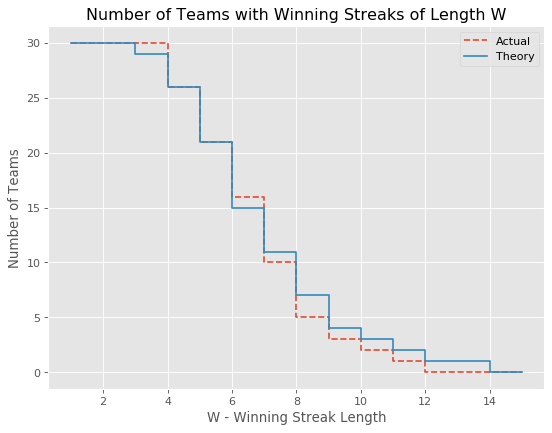

In [12]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.step(np.arange(streak_size)+1,cum_win_streaks,linestyle = '--',label='Actual')
plt.step(np.arange(streak_size)+1,np.round(win_predict),label='Theory')
plt.legend()
plt.title('Number of Teams with Winning Streaks of Length W')
plt.xlabel('W - Winning Streak Length')
plt.ylabel('Number of Teams')
plt.show()

We can do the same for losing streaks. 

In [13]:
streak_size = 15
lose_percent, games_played = winning_percentage(streaks)
real_lose_streaks  = np.zeros(streak_size)
cum_lose_streaks  = np.zeros(streak_size)
lose_predict = np.zeros(streak_size)
for t in streaks:
    x = (np.arange(np.size(streaks[t][1])))
    cumulative_losses = np.cumsum(streaks[t][1][::-1])[::-1] 
    ind_non_zero = np.where(streaks[t][1] > 0)
    cind_non_zero = np.where(cumulative_losses > 0)
    real_lose_streaks[x[ind_non_zero]] += 1
    cum_lose_streaks[x[cind_non_zero]] += 1
    for p in np.arange(streak_size):
        lose_predict[p] += probability_of_streak(games_played[t], p+1, lose_percent[t])

At last the human element presents itself. There are much fewer teams with losing streaks greater than 4 and above than predicted by the biniomal distribution alone.  Lose a few games and changes occur; this may be evidence that they work!

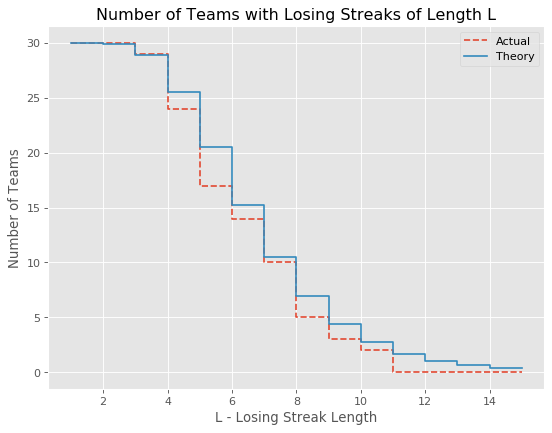

In [14]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.step(np.arange(streak_size)+1,cum_lose_streaks,linestyle = '--',label='Actual')
plt.step(np.arange(streak_size)+1,lose_predict,label='Theory')
plt.legend()
plt.title('Number of Teams with Losing Streaks of Length L')
plt.xlabel('L - Losing Streak Length')
plt.ylabel('Number of Teams')
plt.show()